In [ ]:
%connect_info

In [1]:
from os import listdir
import itertools
import mne
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import hypyp
import pandas as pd
import struct
import itertools as itertools
import snirf
import pdb
from matplotlib.colors import Normalize, LogNorm, NoNorm
import time
import scipy
from scipy import signal
from scipy.fft import ifft, fft, fftfreq
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from copy import deepcopy 

In [3]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import pywt
import pycwt



The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## FUNCTION FROM HYPYP

In [4]:
def xwt_coherence_morl(x1, x2, fs, nNotes=12, detrend=False, normalize=False):
    """
    Calculates the cross wavelet transform coherence between two time series using the Morlet wavelet.

    Arguments:
        x1 : array
            Time series data of the first signal.
        x2 : array
            Time series data of the second signal.
        fs : int
            Sampling frequency of the time series data.
        nNotes : int, optional
            Number of notes per octave for scale decomposition, defaults to 12.
        detrend : bool, optional
            If True, linearly detrends the time series data, defaults to True.
        normalize : bool, optional
            If True, normalizes the time series data by its standard deviation, defaults to True.

    Note:
        This function uses PyWavelets for performing continuous wavelet transforms
        and scipy.ndimage for filtering operations.

    Returns:
        WCT : array
            Wavelet coherence transform values.
        times : array
            Time points corresponding to the time series data.
        frequencies : array
            Frequencies corresponding to the wavelet scales.
        coif : array
            Cone of influence in frequency, reflecting areas in the time-frequency space
            affected by edge artifacts.
    """
    # Assertions and initial computations
    N1 = len(x1)
    N2 = len(x2)
    assert (N1 == N2), "error: arrays not same size"
   
    N = N1
    dt = 1.0 / fs
    times = np.arange(N) * dt
 
    # Data preprocessing: detrend and normalize
    if detrend:
        x1 = signal.detrend(x1, type='linear')
        x2 = signal.detrend(x2, type='linear')
    if normalize:
        stddev1 = x1.std()
        x1 = x1 / stddev1
        stddev2 = x2.std()
        x2 = x2 / stddev2
 
    # Wavelet transform parameters
    nOctaves = int(np.log2(2 * np.floor(N / 2.0)))
    scales = 2 ** np.arange(1, nOctaves, 1.0 / nNotes)
    coef1, freqs1 = pywt.cwt(x1, scales, 'cmor2.5-1.0', )
    coef2, freqs2 = pywt.cwt(x2, scales, 'cmor2.5-1.0')
    frequencies = pywt.scale2frequency('cmor2.5-1.0', scales) / dt

    # Compute cross wavelet transform and coherence
    coef12 = coef1 * coef2.conj()
    scaleMatrix = np.ones([1, N]) * scales[:, None]

    def rect(length, normalize=False):
        """ Rectangular function adapted from https://github.com/regeirk/pycwt/blob/master/pycwt/helpers.py

        Args:
            length (int): length of the rectangular function
            normalize (bool): normalize or not

        Returns:
            rect (array): the (normalized) rectangular function

        """
        rect = np.zeros(length)
        rect[0] = rect[-1] = 0.5
        rect[1:-1] = 1

        if normalize:
            rect /= rect.sum()

        return rect

    def smoothing(coeff, snorm, dj, smooth_factor=0.1):
        """ Smoothing function adapted from https://github.com/regeirk/pycwt/blob/master/pycwt/helpers.py

        Args
        ----

        coeff : array
            the wavelet coefficients get from wavelet transform **in the form of a1 + a2*1j**
        snorm : array
            normalized scales
        dj : float
            it satisfies the equation [ Sj = S0 * 2**(j*dj) ]

        Returns
        -------

        rect : array
            the (normalized) rectangular function

        """
        def fft_kwargs(signal, **kwargs):
            return {'n': int(2 ** np.ceil(np.log2(len(signal))))}
        
        W = coeff #.transpose()
        m, n = np.shape(W)

        # Smooth in time
        k = 2 * np.pi * fftfreq(fft_kwargs(W[0, :])['n'])
        k2 = k ** 2
        # Notes by Smoothing by Gaussian window (absolute value of wavelet function)
        # using the convolution theorem: multiplication by Gaussian curve in
        # Fourier domain for each scale, outer product of scale and frequency
        
        F = np.exp(-smooth_factor * (snorm[:, np.newaxis] ** 2) * k2)  # Outer product

        smooth = ifft(F * fft(W, axis=1, **fft_kwargs(W[0, :])),
                          axis=1,  # Along Fourier frequencies
                          **fft_kwargs(W[0, :], overwrite_x=True))
        T = smooth[:, :n]  # Remove possibly padded region due to FFT
        if np.isreal(W).all():
            T = T.real

        # Smooth in scale
        wsize = 0.6 / dj * 2
        win = rect(int(np.round(wsize)), normalize=True)
        T = signal.convolve2d(T, win[:, np.newaxis], 'same')

        return T

    scales = 1 / freqs1

    s0 = scales[0]
    sN = scales[-1]
    dj = np.log2(sN/s0) / np.size(scales)

    # def smoothing(X, snorm, dj):
    #     return scipy.ndimage.gaussian_filter(X, sigma=[9, 1])
    
    S1 = smoothing(np.abs(coef1) ** 2 / scaleMatrix, scales, dj)
    S2 = smoothing(np.abs(coef2) ** 2 / scaleMatrix, scales, dj)
    S12 = smoothing(coef12 / scaleMatrix, scales, dj)
    WCT = np.abs(S12) ** 2 / (S1 * S2)

    # Cone of influence calculations
    f0 = 2 * np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4 * np.pi / (f0 + np.sqrt(2 + f0**2))
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    coif = 1.0 / coi
 
    return WCT, times, frequencies, coif

In [5]:
def spectrogram_plot(z, times, frequencies, coif, cmap="viridis", norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = cm.get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = plt.colormaps[cmap]

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    if norm is None:
        im = ax.pcolor(xx,yy,ZZ, cmap=cmap)
        ax.plot(times,coif)
        ax.fill_between(times,coif, step="mid", alpha=0.4)
    else:
        im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
        ax.plot(times,coif)
        ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

In [6]:
def spectrogram_plot_period(z, times, frequencies, coif, cmap="viridis", norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = cm.get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = plt.colormaps[cmap]

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    periods = np.log2(5/frequencies)

    ntimes = 5*times
    
    xx,yy = np.meshgrid(ntimes,periods)
    ZZ = z
    
    if norm is None:
        im = ax.pcolor(xx,yy,ZZ, cmap=cmap)
        ax.plot(ntimes,coif)
        ax.fill_between(times,coif, step="mid", alpha=0.4)
    else:
        im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
        ax.plot(ntimes,coif)
        ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(ntimes.min(), ntimes.max())
    ax.set_ylim(periods.min(), periods.max())

    steps = np.arange(0, len(periods), 10)
    ax.set_yticks(periods[steps], 2**(periods[steps]))
    
    ax.invert_yaxis()
    
    return ax

## Load snirfs

In [12]:
session_n = 1
prep_path = '../data/'
fileList = []
pair_list = []
group_results = []
freq_bins = 5
freqs = np.linspace(0.1, 0.5, freq_bins)
sfreq = 5
coi = 2.5*5/freqs #sfreq = 5

fname1 = 'sub-110_session-1_pre_raw.fif'
fname2 = 'sub-110_session-1_pre_raw.fif'
p1 = prep_path + fname1
p2 = prep_path + fname2

chs1 = ["S4_D4 hbo"] 
chs2 = ["S7_D6 hbo"]

#set events
tmin = 0 
tmax = 300
baseline = (0, 0)

# read in data 1
p1 = mne.io.read_raw_fif(p1, verbose=True, preload=True)
p2 = mne.io.read_raw_fif(p2, verbose=True, preload=True)

# select channels from csv of best channels
ch_list1 = chs1
ch_list2 = chs2
ch_picks1 = mne.pick_channels(p1.ch_names, include = ch_list1)
ch_picks2 = mne.pick_channels(p2.ch_names, include = ch_list2)
p1_best_ch = p1.copy().pick(ch_picks1)
p2_best_ch = p2.copy().pick(ch_picks2)

# get events
events1, event_dict1 = mne.events_from_annotations(p1_best_ch)
events2, event_dict2 = mne.events_from_annotations(p2_best_ch)
epo1 = mne.Epochs(p1_best_ch, events1,
                  event_id = event_dict1, tmin = tmin, tmax = tmax,
                  baseline = baseline, reject_by_annotation=False)
epo2 = mne.Epochs(p2_best_ch, events2,
                  event_id = event_dict2, tmin = tmin, tmax = tmax,
                  baseline = baseline, reject_by_annotation=False)

Opening raw data file ../data/sub-110_session-1_pre_raw.fif...


    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Opening raw data file ../data/sub-110_session-1_pre_raw.fif...
    Range : 0 ... 5579 =      0.000 ...  1115.800 secs
Ready.
Reading 0 ... 5579  =      0.000 ...  1115.800 secs...
Used Annotations descriptions: ['1', '2', '3', '4']
Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


## Sine waves

Using data from preloaded Raw for 4 events and 1501 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 4 events and 1501 original time points ...
1 bad epochs dropped


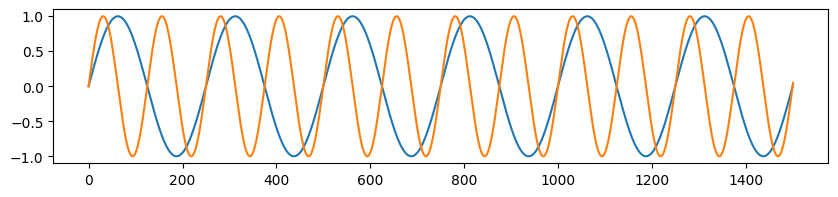

<Figure size 640x480 with 0 Axes>

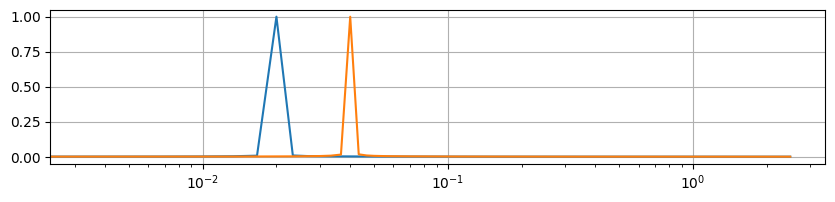

In [13]:
plt.figure(figsize=(10,2))

sig1_P1 = epo1.get_data()[0,0,:]
times_vec = np.linspace(0, sig1_P1.shape[0] / 5, sig1_P1.shape[0])
freq1 = .1
sig1_P1 = np.sin(times_vec * 2 * np.pi * freq1 / 5) # IS /5 correct!?
#sig1_P1 = np.random.randn(*sig1_P1.shape) #np.finfo(float).eps*np.ones(*sig1_P1.shape) 
plt.plot(sig1_P1)

sig1_P2 = epo2.get_data()[0,0,:]
freq2 = 0.2 
sig1_P2 = np.sin(times_vec * 2 * np.pi * freq2 / 5)
#sig1_P2 = np.random.randn(*sig1_P2.shape) #np.finfo(float).eps*np.ones(*sig1_P2.shape) 
plt.plot(sig1_P2)

plt.figure()

plt.figure(figsize=(10,2))
N = 1501
# sample spacing
T = 1.0 / 5.0
yf = fft(sig1_P1)
xf = fftfreq(N, T)[:N//2]
yf2 = fft(sig1_P2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.plot(xf, 2.0/N * np.abs(yf2[0:N//2]))
plt.xscale('log')
plt.grid()
plt.show()

In [14]:
wtc_morlet = xwt_coherence_morl(sig1_P1, sig1_P2,5)
wtc, times, fq, coif = deepcopy(wtc_morlet)
            
#lists for df
print(wtc[55:77,:].mean())

0.21287877283191595


In [15]:
import pycwt

In [16]:
WCT, aWCT, coi, freq, sig = pycwt.wct(sig1_P1, sig1_P2, dt=1/5, sig=False)

In [17]:
print(WCT[55:77,:].mean())

0.7486786363095698


<Axes: >

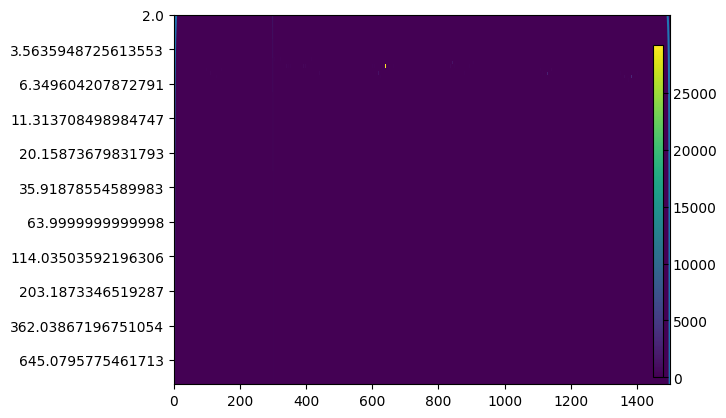

In [18]:
spectrogram_plot_period(np.abs(wtc), times, fq, coif)

<Axes: >

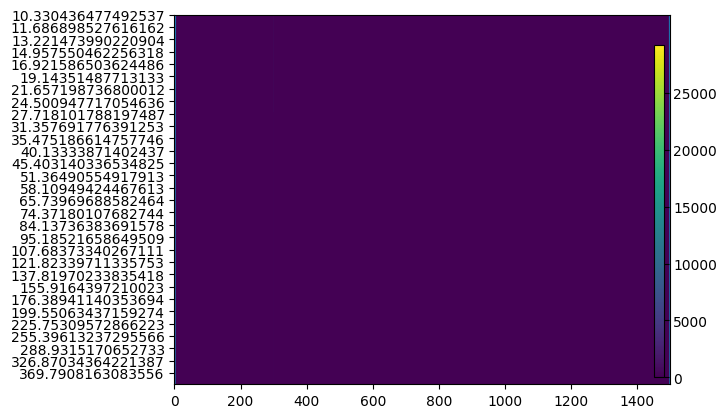

In [20]:
spectrogram_plot_period(np.abs(WCT), times, freq, coif)